# Classification : Signal events from background events

In [120]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [121]:
!pip install tensorflow-quantum==0.7.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-3.17.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.22.1
    Uninstalling protobuf-4.22.1:
      Successfully uninstalled protobuf-4.22.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-hub 0.13.0 requires protobuf>=3.19.6, but you have protobuf 3.17.3 which is incompatible.
tensorboard 2.12.0 requires protobuf>=3.19.6, but you have protobuf 3.17.3 which is incompatible.
proto-plus 1.22.2 requires protobuf<5.0.0dev,>=3.19.0, but you have protobuf 3.17.3 which is incompatible.
google-cloud-translate 3.8.4 requires google-api-core[grpc]!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<3.0.0dev,>=1.32.0, but you have google-a

In [122]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py'>

## Data Preprocessing

In [123]:
import numpy as np

In [124]:
# Load data
dataset = []
dataset = np.load('QIS_EXAM_200Events.npz',allow_pickle = True)

In [125]:
for i in dataset.keys():
    print(i)

training_input
test_input


In [126]:
dataset # 0:Signal events 1:Background events

In [127]:
X_train = dataset['training_input'].item()['0']
y_train = dataset['training_input'].item()['1']

In [128]:
X_test = dataset['test_input'].item()['0']
y_test = dataset['test_input'].item()['1']

In [129]:
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score

In [130]:
import cirq

In [131]:
import sympy

In [132]:
# Define the qubits
qubits = [cirq.GridQubit(0, i) for i in range(4)]

# Convert each input feature to a circuit
X_train_circuits = []
for x in X_train:
    circuit = cirq.Circuit()
    for i, xi in enumerate(x):
        if xi == 1:
            circuit.append(cirq.X(qubits[i]))
    circuit.append(cirq.measure(*qubits, key='result'))
    X_train_circuits.append(circuit)

# Convert y_train to tensor
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Convert X_train to tensor
X_train_tensor = tfq.convert_to_tensor(X_train_circuits)

In [133]:
N_TRAIN = 5

In [134]:
X_train.shape

(50, 5)

In [135]:
X_train_tensor.shape

TensorShape([50])

In [136]:
N_QUBITS = 5

In [137]:
LATENT_DIM = 50
def make_generator_model():
    """Construct generator model."""
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(N_QUBITS, activation='relu'))

    return model

def make_discriminator_model():
    """Construct discriminator model."""
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(N_QUBITS,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    return model

In [138]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [139]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    """Compute discriminator loss."""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Compute generator loss."""
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [140]:
BATCH_SIZE=256

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [141]:
import time

In [142]:
g_loss_history = []
d_loss_history = []

In [143]:
def train(dataset, epochs, start_epoch=1):
    """Launch full training run for the given number of epochs."""
    # Log original training distribution.
    batched_data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(N_TRAIN).batch(512)
    t = time.time()
    for epoch in range(start_epoch, start_epoch + epochs):
        for i, image_batch in enumerate(batched_data):
            # Log batch-wise loss.
            gl, dl = train_step(image_batch)
            g_loss_history.append(gl)
            d_loss_history.append(dl)
            tf.summary.scalar(
                'Generator loss', data=gl, step=epoch * len(batched_data) + i)
            tf.summary.scalar(
                'Discriminator loss', data=dl, step=epoch * len(batched_data) + i)

        if epoch % 10 == 0:
            print('Epoch {}, took {}(s)'.format(epoch, time.time() - t),'Generator Loss : ',gl.numpy(),'Discriminator Loss :',dl.numpy())
            t = time.time()

In [144]:
train(X_train, epochs=200)

Epoch 10, took 1.3823394775390625(s) Generator Loss :  0.67802554 Discriminator Loss : 1.3172405
Epoch 20, took 0.14287900924682617(s) Generator Loss :  0.69008994 Discriminator Loss : 1.2525606
Epoch 30, took 0.12545299530029297(s) Generator Loss :  0.7062158 Discriminator Loss : 1.1917279
Epoch 40, took 0.12682533264160156(s) Generator Loss :  0.7215365 Discriminator Loss : 1.1214155
Epoch 50, took 0.13112115859985352(s) Generator Loss :  0.7278782 Discriminator Loss : 1.0753934
Epoch 60, took 0.14816069602966309(s) Generator Loss :  0.7231425 Discriminator Loss : 1.0360622
Epoch 70, took 0.1970217227935791(s) Generator Loss :  0.7197968 Discriminator Loss : 0.99409616
Epoch 80, took 0.2293708324432373(s) Generator Loss :  0.71854 Discriminator Loss : 0.94935286
Epoch 90, took 0.14266371726989746(s) Generator Loss :  0.72026074 Discriminator Loss : 0.8975426
Epoch 100, took 0.13276267051696777(s) Generator Loss :  0.72371674 Discriminator Loss : 0.8635783
Epoch 110, took 0.1265430450

In [145]:
g_loss_history[0].numpy()

0.67651474

In [146]:
for i in range(len(g_loss_history)):
  g_loss_history[i] = g_loss_history[i].numpy()
for i in range(len(d_loss_history)):
  d_loss_history[i] = d_loss_history[i].numpy()

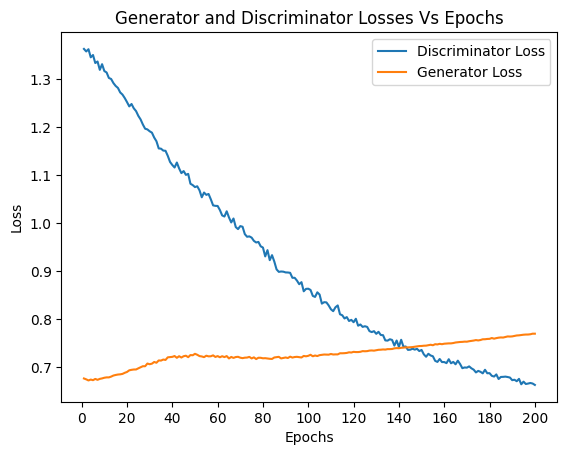

In [147]:
from matplotlib.pylab import plt
from numpy import arange
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 201)
 
# Plot and label the training and validation loss values
plt.plot(epochs, d_loss_history, label='Discriminator Loss')
plt.plot(epochs, g_loss_history, label='Generator Loss')
 
# Add in a title and axes labels
plt.title('Generator and Discriminator Losses Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 201, 20))
 
# Display the plot
plt.legend(loc='best')
plt.show()